[ref](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tweedie

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

In [2]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data

from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [4]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
ngpu=0

In [5]:
n_samples = 10**5
n_feats = 25

In [6]:
x = np.random.randn(n_samples, n_feats)
w = np.random.randn(n_feats) * 0.1

mus = np.exp(x.dot(w))
y = tweedie.tweedie(mu=mus, p=1.5, phi=1).rvs() 

### Simple Linear Regression check

In [7]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(x, y)
reg.coef_

array([-0.04453484, -0.04099412, -0.19285496,  0.01331058, -0.14403984,
        0.00924913,  0.14710717, -0.07473427, -0.11923784,  0.08147301,
        0.08804803,  0.21053354, -0.00357033,  0.07623259, -0.12245195,
        0.11591204, -0.02805224,  0.00960302,  0.10405486, -0.15425664,
        0.199198  ,  0.05482115, -0.12857953,  0.22951176,  0.01448748])

In [8]:
reg.score(x, y), (1-reg.score(x, y))*y.var()

(0.19824195557637414, 1.3914423709161208)

# Regress GAN

### Define ANN Architecture

In [9]:
# Batch size during training
batch_size = 64

# Size of z latent vector (i.e. size of generator input)
nz = 5

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.002
# lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# width of the network
network_width = 128

In [10]:
# create train and test indices
train, test = train_test_split(list(range(x.shape[0])), test_size=.2)
train, val = train_test_split(train, test_size=.25)

In [11]:
# https://gist.github.com/conormm/5b26a08029b900520bcd6fcd1f5712a0
class PrepareData(torch.utils.data.Dataset):

    def __init__(self, X, y, scale_X=True):
        if not torch.is_tensor(X):
            if scale_X:
                X = StandardScaler().fit_transform(X)
            self.X = torch.from_numpy(X).float()
        else:
            self.X = X.float32()
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y).float()
        else:
            self.y = y.float32()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

ds = PrepareData(x, y=y, scale_X=False)

train_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
                       sampler=SubsetRandomSampler(train))
val_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
                       sampler=SubsetRandomSampler(val))
test_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
                      sampler=SubsetRandomSampler(test))

In [12]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.Linear( n_feats+nz, network_width, bias=True),
            nn.ReLU(True),

            nn.Linear( network_width, network_width, bias=True),
            nn.ReLU(True),

            nn.Linear( network_width, 1, bias=True)

        )

    def forward(self, input):
        return self.main(input)

In [13]:
# Create the generator
netG = Generator(ngpu).to(device)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): Linear(in_features=30, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [14]:
# Discriminator Code

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.Linear(n_feats+1, network_width, bias=True), # i/p is covariates and o/p
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear( network_width, network_width, bias=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear( network_width, 1, bias=True),
            nn.Sigmoid(),

        )

    def forward(self, input):
        return self.main(input)

In [15]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=26, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=128, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [16]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(nz, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [17]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

G_losses_val = []
D_losses_val = []

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_set, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = torch.hstack((data[0],data[1].unsqueeze(1))).to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, device=device)
        # Generate fake image batch with G
        gen_ip = torch.hstack((data[0],noise)).to(device)
        fake = netG(gen_ip)
        
        label.fill_(fake_label)
        # Classify all fake batch with D
        fake_cpu = torch.hstack((data[0],fake.detach())).to(device)
        output = netD(fake_cpu.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        fake_cpu = torch.hstack((data[0],fake)).to(device)
        output = netD(fake_cpu).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 500 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_set),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
                
        # Output validation stats
        if i % 100 == 0:
            with torch.no_grad():
                errG_vals = []
                errD_vals = []
                for i, data in enumerate(val_set, 0):
                    b_size = data[0].size(0)
                    noise = torch.randn(b_size, nz, device=device)
                    # Generate fake image batch with G
                    gen_ip = torch.hstack((data[0],noise)).to(device)
                    gen_op = netG(gen_ip)
                    
                    fake_cpu = torch.hstack((data[0],gen_op)).to(device)
                    fake_output = netD(fake_cpu).view(-1)

                    label.fill_(real_label) # fake labels are real for generator cost
                    errG_val = criterion(output, label)  
                    
                    label.fill_(fake_label)
                    errD_fake_val = criterion(output, label)
                    
                    real_cpu = torch.hstack((data[0],data[1].unsqueeze(1))).to(device)
                    real_output = netD(real_cpu).view(-1)
                    
                    label.fill_(real_label)
                    errD_real_val = criterion(output, label)
                    
                    errG_vals.append(errG_val.item())
                    errD_vals.append((errD_fake_val+errD_real_val).item())
            G_losses_val.append(sum(errG_vals)/len(errG_vals))
            D_losses_val.append(sum(errD_vals)/len(errD_vals))
        
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        # if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_set)-1)):
        #     with torch.no_grad():
        #         fake = netG(fixed_noise).detach().cpu()
        #     img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/10][0/938]	Loss_D: 1.3706	Loss_G: 0.6997	D(x): 0.5039	D(G(z)): 0.4953 / 0.4970
[0/10][500/938]	Loss_D: 1.3722	Loss_G: 0.7493	D(x): 0.4782	D(G(z)): 0.4686 / 0.4734
[1/10][0/938]	Loss_D: 1.3794	Loss_G: 0.7347	D(x): 0.4854	D(G(z)): 0.4810 / 0.4803
[1/10][500/938]	Loss_D: 1.3833	Loss_G: 0.6911	D(x): 0.5028	D(G(z)): 0.5012 / 0.5011
[2/10][0/938]	Loss_D: 1.3826	Loss_G: 0.6910	D(x): 0.5046	D(G(z)): 0.5027 / 0.5012
[2/10][500/938]	Loss_D: 1.3926	Loss_G: 0.6892	D(x): 0.5020	D(G(z)): 0.5048 / 0.5021
[3/10][0/938]	Loss_D: 1.3870	Loss_G: 0.7013	D(x): 0.4953	D(G(z)): 0.4955 / 0.4960
[3/10][500/938]	Loss_D: 1.3851	Loss_G: 0.6985	D(x): 0.4965	D(G(z)): 0.4958 / 0.4974
[4/10][0/938]	Loss_D: 1.3861	Loss_G: 0.6800	D(x): 0.5087	D(G(z)): 0.5084 / 0.5066
[4/10][500/938]	Loss_D: 1.3864	Loss_G: 0.6989	D(x): 0.4978	D(G(z)): 0.4978 / 0.4971
[5/10][0/938]	Loss_D: 1.3899	Loss_G: 0.6913	D(x): 0.5037	D(G(z)): 0.5054 / 0.5010
[5/10][500/938]	Loss_D: 1.3842	Loss_G: 0.6855	D(x): 0.5046	D(G

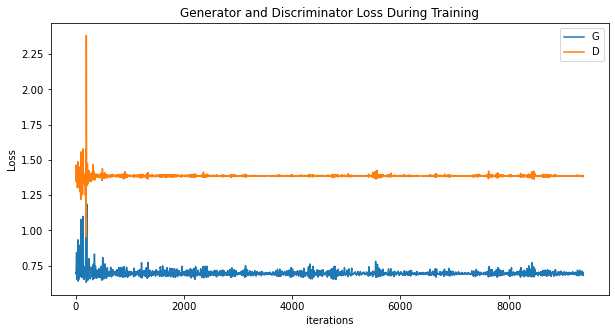

In [18]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

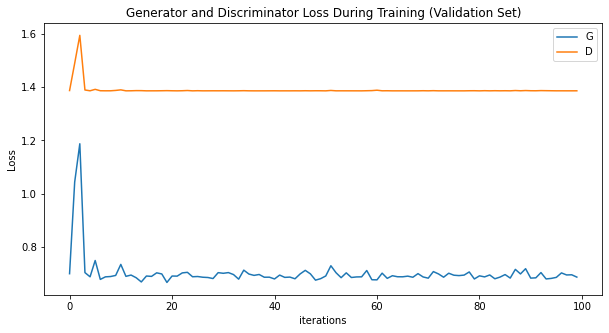

In [19]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training (Validation Set)")
plt.plot(G_losses_val,label="G")
plt.plot(D_losses_val,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Train Predictions

In [20]:
train_ops = []
with torch.no_grad():
    for i, data in enumerate(train_set, 0):
        b_size = data[0].size(0)
        noise = torch.randn(b_size, nz, device=device)
        # Generate fake image batch with G
        gen_ip = torch.hstack((data[0],noise)).to(device)
        fake = netG(gen_ip)
        
        train_ops.append(
            (data[1].detach().cpu().numpy(), fake.detach().cpu().numpy())
        )

In [21]:
train_reals = np.concatenate(list(x[0] for x in train_ops))
train_preds = np.concatenate(list(x[1] for x in train_ops))

In [22]:
df_results_train = pd.DataFrame(
    data = np.hstack((
    np.expand_dims(train_reals,1),train_preds
    ))
    ,columns = ["true","pred"]
)

df_results_train.describe()

,true,pred
count,60000.000000,60000.000000
mean,1.140803,0.930427
std,1.321923,1.171411
min,0.000000,-0.749130
25%,0.188318,0.169680
50%,0.731551,0.346609
75%,1.634366,1.430749
max,20.873404,9.445747


In [23]:
df_results_train["pred_segment"] = pd.qcut(df_results_train["pred"],10)
df_results_train.groupby("pred_segment").mean()

,true,pred
pred_segment,,
"(-0.75, 0.0223]",0.974380,-0.107084
"(0.0223, 0.13]",0.939275,0.080561
"(0.13, 0.203]",0.900054,0.168575
"(0.203, 0.269]",0.892566,0.235266
"(0.269, 0.347]",0.860776,0.304247
"(0.347, 0.641]",1.044741,0.468323
"(0.641, 1.132]",1.194235,0.875234
"(1.132, 1.759]",1.316839,1.433105
"(1.759, 2.664]",1.477380,2.176378


In [24]:
mean_squared_error(df_results_train["true"], df_results_train["pred"]), df_results_train["true"].var()

(2.4666026, 1.7474799)

In [25]:
mean_absolute_error(df_results_train["true"], df_results_train["pred"]), (
    df_results_train["true"]-df_results_train["true"].mean()
).abs().mean()

(1.0879179, 0.9557712)

## Test Predictions

In [26]:
test_ops = []
with torch.no_grad():
    for i, data in enumerate(test_set, 0):
        b_size = data[0].size(0)
        noise = torch.randn(b_size, nz, device=device)
        # Generate fake image batch with G
        gen_ip = torch.hstack((data[0],noise)).to(device)
        fake = netG(gen_ip)
        
        test_ops.append(
            (data[1].detach().cpu().numpy(), fake.detach().cpu().numpy())
        )

In [27]:
test_reals = np.concatenate(list(x[0] for x in test_ops))
test_preds = np.concatenate(list(x[1] for x in test_ops))

In [28]:
df_results = pd.DataFrame(
    data = np.hstack((
    np.expand_dims(test_reals,1),test_preds
    ))
    ,columns = ["true","pred"]
)

df_results.describe()

,true,pred
count,20000.000000,20000.000000
mean,1.116001,0.913647
std,1.289833,1.148619
min,0.000000,-0.696088
25%,0.187365,0.168847
50%,0.717745,0.341176
75%,1.585128,1.408507
max,14.393881,8.373297


In [29]:
df_results["pred_segment"] = pd.qcut(df_results["pred"],10)
df_results.groupby("pred_segment").mean()

,true,pred
pred_segment,,
"(-0.697, 0.0196]",0.976896,-0.106835
"(0.0196, 0.129]",0.948799,0.078347
"(0.129, 0.202]",0.919655,0.167628
"(0.202, 0.265]",0.879142,0.232831
"(0.265, 0.341]",0.845454,0.300639
"(0.341, 0.619]",1.018534,0.454362
"(0.619, 1.118]",1.140400,0.853109
"(1.118, 1.74]",1.294748,1.415770
"(1.74, 2.608]",1.451416,2.147382


In [30]:
mean_squared_error(df_results["true"], df_results["pred"]), df_results["true"].var()

(2.4040692, 1.6636693)

In [31]:
mean_absolute_error(df_results["true"], df_results["pred"]), (
    df_results["true"]-df_results["true"].mean()
).abs().mean()

(1.07477, 0.9340843)

## Test Predictions (averaged)

In [32]:
N_SAMPLES = 100
test_ops = []
with torch.no_grad():
    for i, data in enumerate(test_set, 0):
        b_size = data[0].size(0)
        fakes = []
        for _ in range(N_SAMPLES):
            noise = torch.randn(b_size, nz, device=device)
            # Generate fake image batch with G
            gen_ip = torch.hstack((data[0],noise)).to(device)
            fake = netG(gen_ip).detach().cpu().numpy()
            fakes.append(fake)

        test_ops.append(
            (data[1].detach().cpu().numpy(), sum(fakes)/len(fakes))
        )
# print(test_reals.shape,np.concatenate(list(x[0] for x in test_ops)).shape)
# print(test_preds.shape,np.concatenate(list(x[1] for x in test_ops)).shape)
test_reals = np.concatenate(list(x[0] for x in test_ops))
test_preds = np.concatenate(list(x[1] for x in test_ops))


In [33]:
df_results = pd.DataFrame(
    data = np.hstack((
    np.expand_dims(test_reals,1),test_preds
    ))
    ,columns = ["true","pred"]
)

df_results.describe()

,true,pred
count,20000.000000,20000.000000
mean,1.116001,0.922601
std,1.289833,0.565379
min,0.000000,-0.098318
25%,0.187365,0.503802
50%,0.717745,0.795515
75%,1.585128,1.207875
max,14.393881,4.963004


In [34]:
df_results["pred_segment"] = pd.qcut(df_results["pred"],10)
df_results.groupby("pred_segment").mean()

,true,pred
pred_segment,,
"(-0.0993, 0.335]",0.444666,0.243693
"(0.335, 0.45]",0.610178,0.394244
"(0.45, 0.555]",0.688883,0.503140
"(0.555, 0.672]",0.809258,0.613146
"(0.672, 0.796]",0.970570,0.733065
"(0.796, 0.935]",1.090801,0.863593
"(0.935, 1.106]",1.188482,1.016981
"(1.106, 1.323]",1.341295,1.210058
"(1.323, 1.694]",1.597580,1.492212


In [35]:
mean_squared_error(df_results["true"], df_results["pred"]), df_results["true"].var()

(1.3671095, 1.6636693)

In [36]:
mean_absolute_error(df_results["true"], df_results["pred"]), (
    df_results["true"]-df_results["true"].mean()
).abs().mean()

(0.8054519, 0.9340842)

# MSE model

### Define ANN Architecture

In [37]:
# Batch size during training
batch_size = 64

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.002
# lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# width of the network
network_width = 128

In [38]:
# # create train and test indices
# train, test = train_test_split(list(range(x.shape[0])), test_size=.2)
# train, val = train_test_split(train, test_size=.25)

In [39]:
# # https://gist.github.com/conormm/5b26a08029b900520bcd6fcd1f5712a0
# class PrepareData(torch.utils.data.Dataset):

#     def __init__(self, X, y, scale_X=True):
#         if not torch.is_tensor(X):
#             if scale_X:
#                 X = StandardScaler().fit_transform(X)
#             self.X = torch.from_numpy(X).float()
#         else:
#             self.X = X.float32()
#         if not torch.is_tensor(y):
#             self.y = torch.from_numpy(y).float()
#         else:
#             self.y = y.float32()

#     def __len__(self):
#         return len(self.X)

#     def __getitem__(self, idx):
#         return self.X[idx], self.y[idx]

# ds = PrepareData(x, y=y, scale_X=False)

# train_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
#                        sampler=SubsetRandomSampler(train))
# val_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
#                        sampler=SubsetRandomSampler(val))
# test_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
#                       sampler=SubsetRandomSampler(test))

In [40]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.Linear( n_feats, network_width, bias=True),
            nn.ReLU(True),

            nn.Linear( network_width, network_width, bias=True),
            nn.ReLU(True),

            nn.Linear( network_width, 1, bias=True)

        )

    def forward(self, input):
        return self.main(input)

In [41]:
# Create the generator
netG = Generator(ngpu).to(device)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): Linear(in_features=25, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [42]:
# Initialize MSELoss function
criterion = nn.MSELoss()

# Setup Adam optimizers for G
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [43]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

G_losses_val = []
D_losses_val = []

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_set, 0):
        
        b_size = data[0].size(0)

        ############################
        # Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label = data[1]  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netG(data[0]).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 500 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_set),
                     0, errG.item(), 0, 0, D_G_z2))
                
        # Output validation stats
        if i % 100 == 0:
            with torch.no_grad():
                errG_vals = []
                for i, data in enumerate(val_set, 0):
                    b_size = data[0].size(0)
                    output = netG(data[0]).view(-1)

                    label = data[1] # fake labels are real for generator cost
                    errG_val = criterion(output, label)  

                    errG_vals.append(errG_val.item())
            G_losses_val.append(sum(errG_vals)/len(errG_vals))
        
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
      
        iters += 1

Starting Training Loop...
[0/10][0/938]	Loss_D: 0.0000	Loss_G: 2.4143	D(x): 0.0000	D(G(z)): 0.0000 / 0.0702
[0/10][500/938]	Loss_D: 0.0000	Loss_G: 1.5969	D(x): 0.0000	D(G(z)): 0.0000 / 1.1973
[1/10][0/938]	Loss_D: 0.0000	Loss_G: 1.3374	D(x): 0.0000	D(G(z)): 0.0000 / 0.9071
[1/10][500/938]	Loss_D: 0.0000	Loss_G: 1.0210	D(x): 0.0000	D(G(z)): 0.0000 / 1.1128
[2/10][0/938]	Loss_D: 0.0000	Loss_G: 1.3756	D(x): 0.0000	D(G(z)): 0.0000 / 1.1110
[2/10][500/938]	Loss_D: 0.0000	Loss_G: 1.5812	D(x): 0.0000	D(G(z)): 0.0000 / 1.2290
[3/10][0/938]	Loss_D: 0.0000	Loss_G: 0.9601	D(x): 0.0000	D(G(z)): 0.0000 / 1.1203
[3/10][500/938]	Loss_D: 0.0000	Loss_G: 2.8814	D(x): 0.0000	D(G(z)): 0.0000 / 1.2901
[4/10][0/938]	Loss_D: 0.0000	Loss_G: 1.3834	D(x): 0.0000	D(G(z)): 0.0000 / 1.2258
[4/10][500/938]	Loss_D: 0.0000	Loss_G: 2.0998	D(x): 0.0000	D(G(z)): 0.0000 / 1.2214
[5/10][0/938]	Loss_D: 0.0000	Loss_G: 0.8554	D(x): 0.0000	D(G(z)): 0.0000 / 1.1599
[5/10][500/938]	Loss_D: 0.0000	Loss_G: 1.1068	D(x): 0.0000	D(G

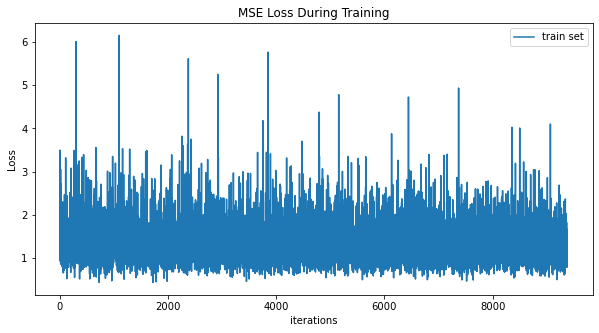

In [44]:
plt.figure(figsize=(10,5))
plt.title("MSE Loss During Training")
plt.plot(G_losses,label="train set")
# plt.plot(G_losses_val,label="val set")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

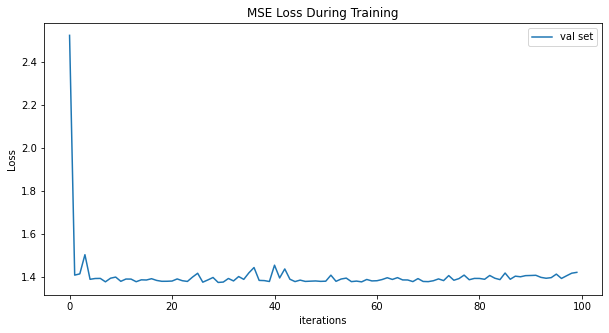

In [45]:
plt.figure(figsize=(10,5))
plt.title("MSE Loss During Training")
# plt.plot(G_losses,label="train set")
plt.plot(G_losses_val,label="val set")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Train Predictions

In [46]:
train_ops = []
with torch.no_grad():
    for i, data in enumerate(train_set, 0):
        b_size = data[0].size(0)
        # Generate fake image batch with G
        fake = netG(data[0])
        
        train_ops.append(
            (data[1].detach().cpu().numpy(), fake.detach().cpu().numpy())
        )

In [47]:
train_reals = np.concatenate(list(x[0] for x in train_ops))
train_preds = np.concatenate(list(x[1] for x in train_ops))

In [48]:
df_results_train = pd.DataFrame(
    data = np.hstack((
    np.expand_dims(train_reals,1),train_preds
    ))
    ,columns = ["true","pred"]
)

df_results_train.describe()

,true,pred
count,60000.000000,60000.000000
mean,1.140803,1.149086
std,1.321923,0.665637
min,0.000000,-0.300142
25%,0.188318,0.707066
50%,0.731551,1.033012
75%,1.634366,1.443962
max,20.873404,9.664511


In [49]:
df_results_train["pred_segment"] = pd.qcut(df_results_train["pred"],10)
df_results_train.groupby("pred_segment").mean()

,true,pred
pred_segment,,
"(-0.301, 0.479]",0.388874,0.355366
"(0.479, 0.637]",0.560435,0.559728
"(0.637, 0.775]",0.682032,0.706868
"(0.775, 0.903]",0.802037,0.839605
"(0.903, 1.033]",0.922022,0.966511
"(1.033, 1.18]",1.066438,1.105537
"(1.18, 1.347]",1.218751,1.261101
"(1.347, 1.553]",1.411506,1.445732
"(1.553, 1.889]",1.726547,1.702781


In [50]:
mean_squared_error(df_results_train["true"], df_results_train["pred"]), df_results_train["true"].var()

(1.2599462, 1.7474799)

In [51]:
mean_absolute_error(df_results_train["true"], df_results_train["pred"]), (
    df_results_train["true"]-df_results_train["true"].mean()
).abs().mean()

(0.8143098, 0.9557712)

## Test Predictions

In [52]:
test_ops = []
with torch.no_grad():
    for i, data in enumerate(test_set, 0):
        b_size = data[0].size(0)
        # Generate fake image batch with G
        gen_ip = data[0] 
        fake = netG(gen_ip)
        
        test_ops.append(
            (data[1].detach().cpu().numpy(), fake.detach().cpu().numpy())
        )

In [53]:
test_reals = np.concatenate(list(x[0] for x in test_ops))
test_preds = np.concatenate(list(x[1] for x in test_ops))

In [54]:
df_results = pd.DataFrame(
    data = np.hstack((
    np.expand_dims(test_reals,1),test_preds
    ))
    ,columns = ["true","pred"]
)

df_results.describe()

,true,pred
count,20000.000000,20000.000000
mean,1.116001,1.138924
std,1.289833,0.644079
min,0.000000,-0.236117
25%,0.187365,0.698456
50%,0.717745,1.029573
75%,1.585128,1.432698
max,14.393881,7.553660


In [55]:
df_results["pred_segment"] = pd.qcut(df_results["pred"],10)
df_results.groupby("pred_segment").mean()

,true,pred
pred_segment,,
"(-0.237, 0.478]",0.453641,0.352631
"(0.478, 0.626]",0.579752,0.553777
"(0.626, 0.772]",0.722690,0.699777
"(0.772, 0.898]",0.777633,0.834931
"(0.898, 1.03]",0.967452,0.962756
"(1.03, 1.176]",1.039180,1.101010
"(1.176, 1.338]",1.234541,1.255533
"(1.338, 1.545]",1.331449,1.438030
"(1.545, 1.882]",1.622752,1.695470


In [56]:
mean_squared_error(df_results["true"], df_results["pred"]), df_results["true"].var()

(1.3345335, 1.6636693)

In [57]:
mean_absolute_error(df_results["true"], df_results["pred"]), (
    df_results["true"]-df_results["true"].mean()
).abs().mean()

(0.835254, 0.9340842)

# Gaussian Process Regression

In [58]:
model = GaussianProcessRegressor(
    kernel=kernels.RBF(length_scale=0.05)
    ,n_restarts_optimizer=10
).fit(x[val], y[val])

In [59]:
model.kernel_.get_params()

{'length_scale': 0.4403830573346016, 'length_scale_bounds': (1e-05, 100000.0)}

In [60]:
y_pred_gauss = model.predict(x[test])
y_true_gauss = y[test]
y_pred_gauss.mean(), y_true_gauss.mean(), y_pred_gauss.std(), y_true_gauss.std()

(6.118821214706439e-10,
 1.1160006215695397,
 4.576774930222722e-08,
 1.289800828042404)

In [61]:
mean_absolute_error(y_true_gauss, y_pred_gauss), (
    np.abs(
        y_true_gauss-y_true_gauss.mean()
    )
).mean()

(1.1160006216798979, 0.9340842166372205)

In [62]:
mean_squared_error(y_true_gauss, y_pred_gauss), (
    np.abs(
        y_true_gauss-y_true_gauss.mean()
    )**2
).mean()

(2.909043562721418, 1.6635861760188708)